# NYC Rideshare Forecasting Pipeline — Part 4: Demand Forecasting

**Author:** K Flowers  
**GitHub:** https://github.com/KRFlowers  
**Date:** December 2025

This notebook builds forecasting models to predict daily NYC rideshare demand. The initial dataset contained 684 million NYC For-Hire Vehicle from 2022–2024. The data has been validated for quality, and analyzed for patterns, and aggregated by zones in previous pipeline notebooks. Forecasting in this analysis is limited to one-day-ahead predictions to validate the modeling approach and is intended solely as a proof of concept.

**Pipeline Position:** Notebook 4 of 4 — Demand Forecasting

- 00_data_download.ipynb  
- 01_data_validation.ipynb  
- 02_exploratory_analysis.ipynb  
- 03_demand_forecasting.ipynb ← **this notebook**

**Objective:**  Build a forecasting model that predicts daily zone-level demand, targeting <10% MAPE.

**Technical Approach:**
- Split data temporally for one-day-ahead time series forecasting (Train: Jan 2022–Jun 2024, Test: Jul–Dec 2024)
- Build and evaluate models on a high-demand pilot zone prior to scaling
- Compare forecasting models: Seasonal Naive (baseline), Prophet, XGBoost
- Perform feature engineering with lag-based features (7-day) aligned with weekly patterns identified during EDA
- Evaluate models using out-of-sample performance measured by MAPE

**Inputs:**
- `zone_daily_high_corr.parquet` — High-correlation zones (195 zones - modeling subset)
- `data/raw/zone_metadata.csv` — Zone names and borough mappings

**Outputs:**
- `data/results/forecast_results.csv` — Daily forecasts with error metrics
- `data/results/summary_results.csv` — Zone-level performance summary

**Runtime:** ~15 minutes

## Model Selection Rationale

Based on EDA findings indicating strong weekly seasonality and relatively stable demand within zones, three forecasting approaches were selected: a Seasonal Naive baseline, Prophet, and XGBoost. These approaches are well suited to capturing temporal patterns without requiring complex seasonal decomposition.

**Seasonal Naive (Baseline):**  
A simple benchmark based on historical demand, implemented here by generating predictions using same-day-last-week values to reflect observed weekly seasonality.

**Prophet:**  
A time series model designed to capture trend and seasonality with minimal feature engineering, configured here to model weekly seasonality.

**XGBoost:**  
A general-purpose gradient boosting machine learning model, adapted here for time series forecasting through feature engineering using lag-based features.

**Note:**  
While EDA identified some monthly seasonality, it was weaker than the dominant weekly pattern and is not modeled explicitly here. Given the one-day-ahead forecasting horizon, recent demand behavior captured through short-term lags was prioritized over longer-term seasonal components. The assumption used here is that rideshare demand is driven primarily by recent behavior rather than long-term seasonal trends, making short-term lag features more appropriate than complex seasonal decomposition.

## 1. Configure Environment

### 1.1 Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuration
import warnings
import logging
warnings.filterwarnings('ignore')
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

print("Libraries imported successfully")

c:\Users\kristi\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


### 1.2 Set Display and Plot Options

In [ ]:
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Visualization settings
sns.set_palette('husl')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 4),
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'legend.framealpha': 0.9,
    'grid.alpha': 0.3,
    'axes.grid': True,
    'axes.grid.axis': 'y'
})
%matplotlib inline

print(f"Display options set")

### 1.3 Set Paths and Constants

In [6]:
# Paths
PROJECT_ROOT = Path("..").resolve()
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "data" / "results"

# Input Files
ZONE_DAILY_FILE = PROCESSED_DIR / "zone_daily_high_corr.parquet"
ZONE_METADATA_FILE = PROJECT_ROOT / "data" / "raw" / "zone_metadata.csv"

# Output Files
FORECAST_RESULTS_FILE = RESULTS_DIR / "forecast_results.csv"
SUMMARY_RESULTS_FILE = RESULTS_DIR / "summary_results.csv"

# Model Parameters
TRAIN_END_DATE = '2024-06-30'
TEST_START_DATE = '2024-07-01'
TEST_END_DATE = '2024-12-31'

# Create Directory
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Paths and constants defined")

Paths and constants defined


### 1.4 Define Helper Functions

**Define Evaluation Metrics**:
- **MAE** (Mean Absolute Error): Primary metric for model selection within zones
- **MAPE** (Mean Absolute Percentage Error): Used for cross-zone comparison and reporting
- **RMSE** (Root Mean Squared Error): Included for completeness; penalizes large errors more heavily

In [3]:
# Create an evaluation function to ensure consistent model comparison with standard metrics across all models (MAE, RMSE, MAPE)

def evaluate_forecast(
    actual: np.ndarray, 
    predicted: np.ndarray, 
    model_name: str = "Model"
) -> dict:
    """Calculate forecast accuracy metrics.
    
    Args:
        actual: Array of actual values
        predicted: Array of predicted values  
        model_name: Name identifier for the model
        
    Returns:
        Dictionary with Model name, MAE, RMSE, and MAPE metrics
    """
    # Convert to numpy arrays to ensure positional alignment
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # Exclude zero-demand days from MAPE (avoids division by zero)
    mask = actual > 0
    mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
    
    return {
        'Model': model_name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE': round(mape, 2)
    }

print("Evaluation function defined")

Evaluation function defined


## 2. Load and Explore Data
Load zone-level aggregated data and verify data quality before modeling.

### 2.1 Load Data

In [7]:
# Load zone-level daily aggregated data and metadata
zone_daily_df = pd.read_parquet(ZONE_DAILY_FILE)
zone_metadata_df = pd.read_csv(ZONE_METADATA_FILE)

# Ensure zone_id is integer type
zone_daily_df['zone_id'] = zone_daily_df['zone_id'].astype(int)

# Sort data and reset index
zone_daily_df = (
    zone_daily_df
    .sort_values(["zone_id", "date"])
    .reset_index(drop=True)
)

print(f" Data loaded:")
print(f"  zone_daily_df: {len(zone_daily_df):,} records ({zone_daily_df['zone_id'].nunique()} zones)")
print(f"  zone_metadata_df: {len(zone_metadata_df):,} records")
print(f"  Date range: {zone_daily_df['date'].min().date()} to {zone_daily_df['date'].max().date()}")

 Data loaded:
  zone_daily_df: 213,720 records (195 zones)
  zone_metadata_df: 265 records
  Date range: 2022-01-01 to 2024-12-31


### 2.2 Review Dataset Structure

In [10]:
# Review dataset structure and target variable distribution

print("Dataset Overview- zone_daily_df")
print(f"  Shape: {zone_daily_df.shape}")
print(f"  Date range: {zone_daily_df['date'].min().date()} to {zone_daily_df['date'].max().date()}")
print(f"  Zones: {zone_daily_df['zone_id'].nunique()}")

print(f"\nTarget Variable")
print(f"  Target: daily_trips (daily trip count per zone)")
print(f"  Mean: {zone_daily_df['daily_trips'].mean():,.0f} trips/day")
print(f"  Range: {zone_daily_df['daily_trips'].min():,} - {zone_daily_df['daily_trips'].max():,}")

print(f"\nFeatures ({len(zone_daily_df.columns)} columns)")
print(zone_daily_df.columns.tolist())

zone_daily_df.head()

Dataset Overview- zone_daily_df
  Shape: (213720, 17)
  Date range: 2022-01-01 to 2024-12-31
  Zones: 195

Target Variable
  Target: daily_trips (daily trip count per zone)
  Mean: 2,624 trips/day
  Range: 55 - 19,910

Features (17 columns)
['zone_id', 'date', 'daily_trips', 'daily_total_minutes', 'daily_avg_minutes', 'total_trip_miles', 'avg_trip_miles', 'total_fare', 'avg_fare', 'year', 'month', 'day_of_week', 'day_name', 'is_weekend', 'season', 'is_holiday', 'month_name']


,zone_id,date,daily_trips,daily_total_minutes,daily_avg_minutes,total_trip_miles,avg_trip_miles,total_fare,avg_fare,year,month,day_of_week,day_name,is_weekend,season,is_holiday,month_name
0,3,2022-01-01,908,754940.0000,831.4317,4369.0870,4.8118,16304.1300,17.9561,2022,1,5,Saturday,True,winter,False,January
1,3,2022-01-02,775,623338.0000,804.3071,3639.4760,4.6961,13118.2200,16.9267,2022,1,6,Sunday,True,winter,False,January
2,3,2022-01-03,1016,808724.0000,795.9882,4475.0630,4.4046,16348.2300,16.0908,2022,1,0,Monday,False,winter,False,January
3,3,2022-01-04,954,744883.0000,780.7998,3859.5230,4.0456,14844.7500,15.5605,2022,1,1,Tuesday,False,winter,False,January
4,3,2022-01-05,1046,858899.0000,821.1272,4289.9420,4.1013,16761.3500,16.0242,2022,1,2,Wednesday,False,winter,False,January


### 2.3 Verify Data Completeness

**Note:** Zone selection in EDA (02_exploratory_analysis.ipynb) filtered to only zones with full 36-month coverage. All zones in this dataset have complete daily records.

## 3. Create Train/Test Datasets

### 3.1 Create Train/Test Split

**Temporal Train/Test Splitting:** Time series data must be split chronologically to avoid look-ahead bias. Historical data trains the model; future data validates performance.

In [28]:
# Split data into train and test sets
train_df = zone_daily_df[zone_daily_df['date'] <= TRAIN_END_DATE].copy()
test_df = zone_daily_df[zone_daily_df['date'] >= TEST_START_DATE].copy()

print("Train/Test Split")
print(f"\n  Train: {train_df['date'].min().date()} to {train_df['date'].max().date()} ({len(train_df):,} rows)")
print(f"  Test:  {test_df['date'].min().date()} to {test_df['date'].max().date()} ({len(test_df):,} rows)")
print(f"\n  Train months: {train_df['date'].dt.to_period('M').nunique()}")
print(f"  Test months: {test_df['date'].dt.to_period('M').nunique()}")

Train/Test Split

  Train: 2022-01-01 to 2024-06-30 (177,840 rows)
  Test:  2024-07-01 to 2024-12-31 (35,880 rows)

  Train months: 30
  Test months: 6


In [19]:
# Check no temporal overlap between train and test (prevents look-ahead bias)
assert train_df['date'].max() < test_df['date'].min(), "Data leakage: train/test overlap"

# Verify all records accounted for in split
assert len(train_df) + len(test_df) == len(zone_daily_df), "Records lost in split"

print("Split validated: no overlap, no missing records")

Split validated: no overlap, no missing records


### 3.2 Create Pilot Zone Dataset
Select most representative zone (highest correlation to global patterns) for initial model testing.

In [40]:
# Load zone stats with correlations
zone_stats = pd.read_csv(PROCESSED_DIR / "zone_stats_summary.csv")

# Select pilot zone (highest correlation)
pilot_zone_row = zone_stats.sort_values('correlation_to_global', ascending=False).iloc[0]
PILOT_ZONE_ID = int(pilot_zone_row['zone_id'])

# Get zone name (if you have zone metadata)
zone_metadata_df = pd.read_csv(ZONE_METADATA_FILE)
pilot_zone_name = zone_metadata_df[zone_metadata_df['zone_id'] == PILOT_ZONE_ID]['Zone'].values[0]

# Filter to pilot zone
pilot_daily_df = zone_daily_df[zone_daily_df['zone_id'] == PILOT_ZONE_ID].copy()

# Split pilot zone data into train and test sets
pilot_train_df = pilot_daily_df[pilot_daily_df['date'] <= TRAIN_END_DATE].copy().sort_values('date').reset_index(drop=True)
pilot_test_df = pilot_daily_df[pilot_daily_df['date'] >= TEST_START_DATE].copy().sort_values('date').reset_index(drop=True)

print(f"Pilot zone selected: Zone {PILOT_ZONE_ID} ({pilot_zone_name})")
print(f"  Correlation to global: {pilot_zone_row['correlation_to_global']:.3f}")
print(f"  Mean daily trips: {pilot_zone_row['daily_trips_mean']:,.0f}")

Pilot zone selected: Zone 41 (Central Harlem)
  Correlation to global: 0.947
  Mean daily trips: 4,038


## 4. Build Baseline Model (Seasonal Naive)
Establish a simple benchmark using 7-day lag forecasting to preserve day-of-week alignment.

### 4.1 Prepare Data

### 4.1 Prepare Data
No actions needed to prepare baseline for Seasonal Naive.  (only a placeholder)

### 4.2 Train Model
Apply seasonal naive forecasting rule by creating a 7-day lag variable.

In [ ]:
# Apply baseline forecasting rule with 7-day lag to full pilot zone data (before t rain/test split)
pilot_daily_df['baseline_pred'] = pilot_daily_df['daily_trips'].shift(7)


### 4.3 Generate Forecast
Filter to test period and extract baseline predictions.

In [42]:
# filter to test period for evaluation
baseline_train_df = pilot_daily_df[pilot_daily_df['date'] <= TRAIN_END_DATE].copy().sort_values('date').reset_index(drop=True)
baseline_test_df = pilot_daily_df[pilot_daily_df['date'] >= TEST_START_DATE].copy().sort_values('date').reset_index(drop=True)  

print(f"Baseline forecast generated: {len(baseline_test_df)} days")
print(f"Missing values: {baseline_test_df['baseline_pred'].isna().sum()}")

Baseline forecast generated: 184 days
Missing values: 0


### 4.4 Evaluate Results
Calculate forecast accuracy metrics and compare to zone mean demand.

In [43]:
# Calculate baseline metrics

baseline_results = evaluate_forecast(
    pilot_test_df['daily_trips'], 
    pilot_test_df['baseline_pred'],
    model_name="Baseline (Seasonal Naive)"
)

# Calculate zone mean for context
zone_mean = pilot_train_df['daily_trips'].mean()

print(f"BASELINE PERFORMANCE (Zone {PILOT_ZONE_ID} - {pilot_zone_name})")
print(f"\nZone mean demand: {zone_mean:,.0f} trips/day")
print(f"MAE:  {baseline_results['MAE']:,.0f} trips/day ({baseline_results['MAE']/zone_mean*100:.1f}% of mean)")
print(f"RMSE: {baseline_results['RMSE']:,.0f} trips/day")
print(f"MAPE: {baseline_results['MAPE']:.1f}%")

BASELINE PERFORMANCE (Zone 41 - Central Harlem)

Zone mean demand: 3,992 trips/day
MAE:  297 trips/day (7.4% of mean)
RMSE: 393 trips/day
MAPE: 7.1%


**Interpretation:**  The seasonal naïve baseline effectively captures recurring weekly patterns but is slow to adapt to changes in demand level. During periods of stable demand, predictions align well with observed values; however, during demand transitions—such as the late December holiday surge—the model consistently lags behind actual demand. With a test MAPE of 18.8%, this baseline provides a reasonable starting point but highlights the need for models that can adapt to shifting demand dynamics and calendar-driven effects.

### 4.5 Visualize Results

### 4.5 Visualize Results
Plot baseline forecast against actual demand to assess performance.

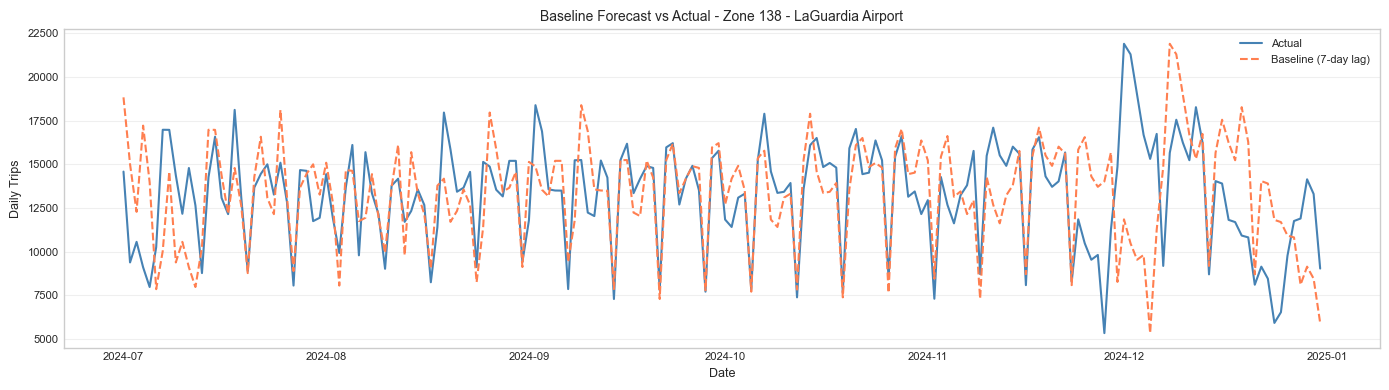

In [41]:
# Plot baseline forecast vs actual demand

fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(pilot_test_df['date'], pilot_test_df['daily_trips'], 
        label='Actual', color='steelblue', linewidth=1.5)
ax.plot(pilot_test_df['date'], pilot_test_df['baseline_pred'], 
        label='Baseline (7-day lag)', color='coral', linewidth=1.5, linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Trips')
ax.set_title(f'Baseline Forecast vs Actual - Zone {PILOT_ZONE_ID} - {pilot_zone_name}')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Build Prophet Model
Trains and evaluates Prophet on the pilot zone.

### 5.1 Prepare Data

In [42]:
pilot_train_df = (
    train_df[train_df["zone_id"] == PILOT_ZONE_ID]
    .sort_values("date")
    .reset_index(drop=True)
)

pilot_test_df = (
    test_df[test_df["zone_id"] == PILOT_ZONE_ID]
    .sort_values("date")
    .reset_index(drop=True)
)

In [43]:
# Format data for Prophet (requires 'ds' and 'y' columns)
prophet_train_df = pilot_train_df[['date', 'daily_trips']].copy()
prophet_train_df.columns = ['ds', 'y']

prophet_test_df = pilot_test_df[['date', 'daily_trips']].copy()
prophet_test_df.columns = ['ds', 'y']

print(f"Prophet train shape: {prophet_train_df.shape}")
print(f"Prophet test shape: {prophet_test_df.shape}")

Prophet train shape: (912, 2)
Prophet test shape: (184, 2)


### 5.2 Train Model

In [ ]:
# Initialize Prophet focused on dominant weekly seasonality
# EDA suggests additive structure (variation does not scale with demand level)

model_prophet = Prophet(
    yearly_seasonality=False,     # Evaluate yearly during tuning if needed
    weekly_seasonality=True,
    daily_seasonality=False,      # Data is daily aggregated
    seasonality_mode='additive',  # EDA showed volatility does not increase with demand
    changepoint_prior_scale=0.05  # Controls trend flexibility (reasonable default)
)

In [45]:
# Train model
model_prophet.fit(prophet_train_df)

print("Prophet model trained")

06:41:37 - cmdstanpy - INFO - Chain [1] start processing
06:41:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained


### 5.3 Generate Forecast

In [46]:
# Generate predictions for test period
future = prophet_test_df[['ds']].copy()
prophet_forecast_df = model_prophet.predict(future)

# Store predictions
pilot_test_df['prophet_pred'] = prophet_forecast_df['yhat'].values

print(f"Prophet forecast generated: {len(prophet_forecast_df)} days")

Prophet forecast generated: 184 days


### 5.4 Evaluate Results

In [47]:
# Calculate Prophet metrics and compare to baseline
prophet_results = evaluate_forecast(
    prophet_test_df['y'],
    prophet_forecast_df['yhat'],
    model_name="Prophet"
)

# Calculate improvement over baseline
improvement_prophet = (baseline_results['MAE'] - prophet_results['MAE']) / baseline_results['MAE'] * 100

print(f"PROPHET PERFORMANCE")
print(f"\nZone mean demand: {zone_mean:,.0f} trips/day")
print(f"MAE:  {prophet_results['MAE']:,.0f} trips/day")
print(f"RMSE: {prophet_results['RMSE']:,.0f} trips/day")
print(f"MAPE: {prophet_results['MAPE']:,.1f}%")
print(f"\nImprovement over baseline: {improvement_prophet:+.1f}%")

PROPHET PERFORMANCE

Zone mean demand: 11,513 trips/day
MAE:  3,115 trips/day
RMSE: 4,211 trips/day
MAPE: 31.0%

Improvement over baseline: -34.4%


**Interpretation:**  The Prophet model underperformed relative to the seasonal naïve baseline, achieving a 23.7% MAPE compared to the baseline's 18.8%. Prophet appeared to fit a weekly curve with mid-week peaks and troughs, which does not align with EDA findings showing a simple 17% weekend lift. The stable weekly pattern in this dataset seems to be more effectively captured by simpler lag-based approaches.

### 5.5 Visualize Results

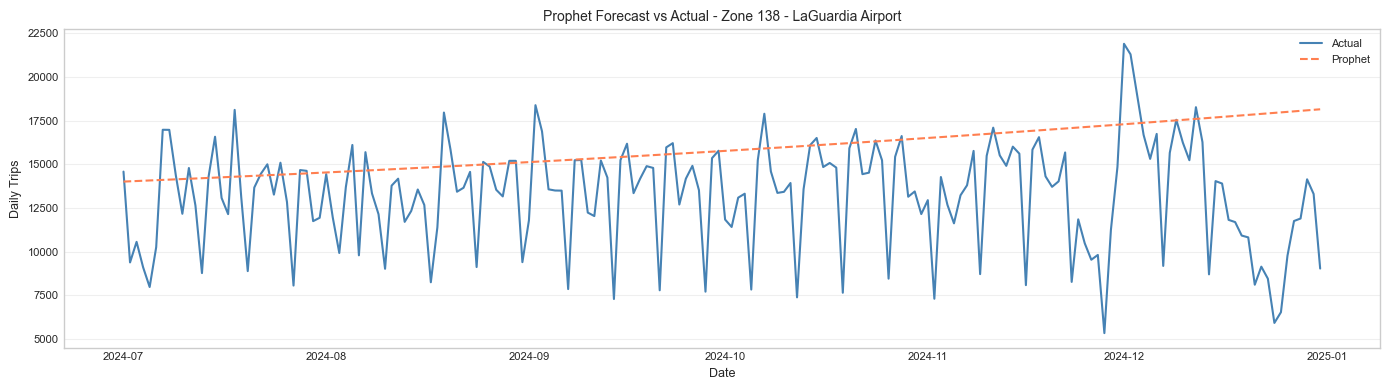

In [48]:
# Plot Prophet forecast vs actual demand

fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(pilot_test_df['date'], pilot_test_df['daily_trips'], 
        label='Actual', color='steelblue', linewidth=1.5)
ax.plot(pilot_test_df['date'], pilot_test_df['prophet_pred'], 
        label='Prophet', color='coral', linewidth=1.5, linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Trips')
ax.set_title(f'Prophet Forecast vs Actual - Zone {PILOT_ZONE_ID} - {pilot_zone_name}')
ax.legend()
plt.tight_layout()
plt.show()

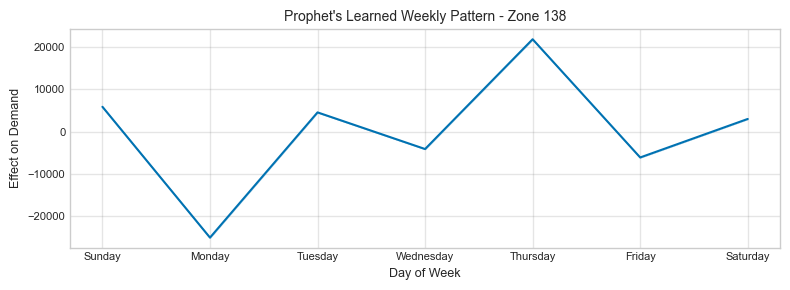

In [49]:
# Examine learned weekly pattern

fig, ax = plt.subplots(figsize=(8, 3))

# Extract weekly component from Prophet
from prophet.plot import plot_weekly
plot_weekly(model_prophet, ax=ax)
ax.set_title("Prophet's Learned Weekly Pattern - Zone 138")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Effect on Demand")
plt.tight_layout()
plt.show()

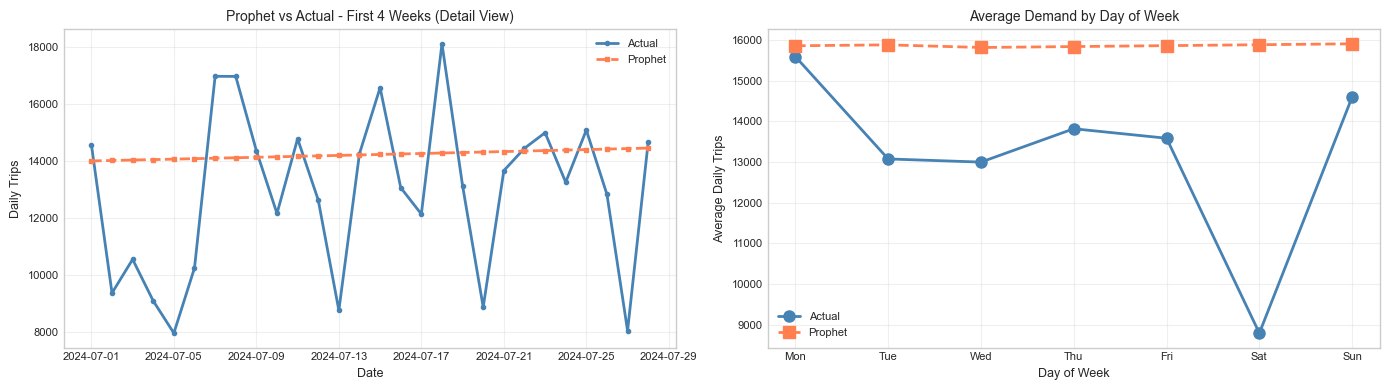

In [50]:
# Diagnostic: Compare Prophet's weekly pattern to actual weekly pattern

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: Zoom into 4 weeks to see Prophet's oscillations
weeks_to_show = 4 * 7  # 28 days
ax = axes[0]
ax.plot(pilot_test_df['date'][:weeks_to_show], 
        pilot_test_df['daily_trips'][:weeks_to_show], 
        label='Actual', color='steelblue', linewidth=2, marker='o', markersize=3)
ax.plot(pilot_test_df['date'][:weeks_to_show], 
        pilot_test_df['prophet_pred'][:weeks_to_show], 
        label='Prophet', color='coral', linewidth=2, marker='s', markersize=3, linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Trips')
ax.set_title('Prophet vs Actual - First 4 Weeks (Detail View)')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Actual vs forecast by day of week
ax = axes[1]
pilot_test_df['day_of_week'] = pd.to_datetime(pilot_test_df['date']).dt.dayofweek
actual_by_dow = pilot_test_df.groupby('day_of_week')['daily_trips'].mean()
prophet_by_dow = pilot_test_df.groupby('day_of_week')['prophet_pred'].mean()

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax.plot(days, actual_by_dow.values, label='Actual', color='steelblue', 
        linewidth=2, marker='o', markersize=8)
ax.plot(days, prophet_by_dow.values, label='Prophet', color='coral', 
        linewidth=2, marker='s', markersize=8, linestyle='--')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Daily Trips')
ax.set_title('Average Demand by Day of Week')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.6 Tune Parameters

In [53]:
# Quick test if tuning would result in meaningful improvements
configs = [
    {'name': 'Additive', 'mode': 'additive'},
    {'name': 'Multiplicative', 'mode': 'multiplicative'},
]

print(f"PROPHET TUNING - Zone {PILOT_ZONE_ID}")
print("=" * 40)
print(f"Baseline MAE: {baseline_results['MAE']:,.0f}\n")

for config in configs:
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode=config['mode'],
        changepoint_prior_scale=0.05
    )
    model.add_country_holidays(country_name='US')
    model.fit(prophet_train_df)
    
    forecast = model.predict(prophet_test_df[['ds']])
    mae = mean_absolute_error(prophet_test_df['y'].values, forecast['yhat'].values)
    vs_baseline = (baseline_results['MAE'] - mae) / baseline_results['MAE'] * 100
    
    print(f"{config['name']}: MAE {mae:,.0f} ({vs_baseline:+.1f}% vs baseline)")

PROPHET TUNING - Zone 138
Baseline MAE: 2,317

Additive: MAE 3,043 (-31.3% vs baseline)
Multiplicative: MAE 2,474 (-6.8% vs baseline)


**Interpretation:** Testing both additive and multiplicative seasonality modes showed consistent underperformance. This suggests the problem is with Prophet's fundamental design, not just model parameters. Prophet does not appear to be the correct tool for this stable, predictable data. The simple weekly lag captures the dominant pattern more effectively.

---

## 6. Build XGBoost Model
Perform feature engineering, trains XGBoost, and analyzes feature importance.

### 6.1 Prepare Data

**Feature Selection Rationale:** Lag-7 was chosen as the primary predictor since EDA revealed stable weekly patterns. Additional features include lag-1 (for short-term trends), rolling_mean_7 (recent week average), and rolling_mean_28 (monthly baseline) to capture different time scales.

In [ ]:
# Engineer lag features for XGBoost (XGBoost needs explicit features for time series modeling)

def create_lag_features(
    df: pd.DataFrame, 
    target_col: str = 'daily_trips', 
    lags: list[int] = [1, 7]
) -> pd.DataFrame:
    """Create lag and rolling features for time series modeling.
    
    Args:
        df: DataFrame with zone_id and target column
        target_col: Name of target variable column
        lags: List of lag periods to create
        
    Returns:
        DataFrame with added lag_N and rolling_mean columns
    """
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby('zone_id')[target_col].shift(lag)
    
    # Rolling features
    df['rolling_mean_7'] = df.groupby('zone_id')[target_col].transform(
        lambda x: x.shift(1).rolling(7, min_periods=1).mean()
    )
    df['rolling_mean_28'] = df.groupby('zone_id')[target_col].transform(
        lambda x: x.shift(1).rolling(28, min_periods=1).mean()
    )
    return df

In [55]:
# Apply to full dataset then re-split
zone_daily_df = create_lag_features(zone_daily_df)

train_xgb_df = zone_daily_df[zone_daily_df['date'] <= TRAIN_END_DATE].copy()
test_xgb_df = zone_daily_df[zone_daily_df['date'] >= TEST_START_DATE].copy()

# Filter to pilot zone
pilot_train_xgb_df = train_xgb_df[train_xgb_df['zone_id'] == PILOT_ZONE_ID].copy()
pilot_test_xgb_df = test_xgb_df[test_xgb_df['zone_id'] == PILOT_ZONE_ID].copy()

print(f"Lag features created: lag_1, lag_7, rolling_mean_7, rolling_mean_28")

Lag features created: lag_1, lag_7, rolling_mean_7, rolling_mean_28


In [ ]:
# Select features to train XGBoost model

FEATURE_COLS = [
    # Time features (from EDA)
    'month', 'day_of_week', 'is_holiday',
    # Lag features
    'lag_1', 'lag_7',
    # Rolling features
    'rolling_mean_7', 'rolling_mean_28'
]

TARGET_COL = 'daily_trips'

# Remove rows with NaN from lag creation
pilot_train_xgb_df = pilot_train_xgb_df.dropna(subset=FEATURE_COLS)
pilot_test_xgb_df = pilot_test_xgb_df.dropna(subset=FEATURE_COLS)

X_train = pilot_train_xgb_df[FEATURE_COLS]
y_train = pilot_train_xgb_df[TARGET_COL]

X_test = pilot_test_xgb_df[FEATURE_COLS]
y_test = pilot_test_xgb_df[TARGET_COL]

print(f"Features: {len(FEATURE_COLS)}")
print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

### 6.2 Train Model

In [ ]:
# Fit XGBoost model on training data
model_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train, y_train)

print("XGBoost model trained")

### 6.3 Generate Forecast

In [ ]:
# Generate predictions on test set
xgb_pred = model_xgb.predict(X_test)

print(f"Predictions generated: {len(xgb_pred)} days")

### 6.4 Evaluate Results

In [ ]:
# Calculate XGBoost metrics and compare to baseline

xgb_results = evaluate_forecast(
    y_test.values, 
    xgb_pred,
    model_name="XGBoost"
)

# Calculate improvement over baseline
improvement_xgb = (baseline_results['MAE'] - xgb_results['MAE']) / baseline_results['MAE'] * 100

print(f"XGBOOST PERFORMANCE (Zone {PILOT_ZONE_ID} - {pilot_zone_name})")
print(f"\nZone mean demand: {zone_mean:,.0f} trips/day")
print(f"MAE:  {xgb_results['MAE']:,.0f} trips/day ({xgb_results['MAE']/zone_mean*100:.1f}% of mean)")
print(f"RMSE: {xgb_results['RMSE']:,.0f} trips/day")
print(f"MAPE: {xgb_results['MAPE']:.1f}%")
print(f"\nImprovement over baseline: {improvement_xgb:+.1f}%")

XGBOOST PERFORMANCE (Zone 138 - LaGuardia Airport)
Zone mean demand: 11,513 trips/day
MAE:  1,453 trips/day (12.6% of mean)
RMSE: 1,945 trips/day
MAPE: 11.6%

vs Baseline: +37.3%


**Interpretation:**  
XGBoost outperforms both the seasonal naïve baseline and Prophet. By leveraging multiple lag-based features rather than a single weekly reference, the model adjusts more quickly during demand transitions. This flexibility results in improved performance during periods of changing demand and lower forecast error.

### 6.5 Visualize Feature Importance

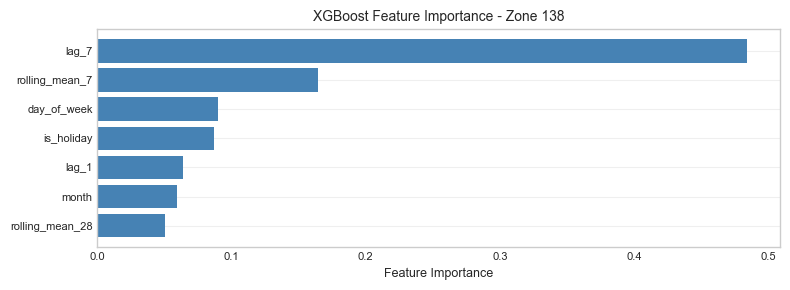

In [60]:
# Display XGBoost feature importance 

importance_df = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 3))
ax.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
ax.set_xlabel('Feature Importance')
ax.set_title(f'XGBoost Feature Importance - Zone {PILOT_ZONE_ID}')
plt.tight_layout()
plt.show()

**Interpretation:** Feature importance confirms `lag_7` as the primary predictor. This confirms the EDA finding that weekly patterns drive demand.

---

## 7. Compare Models
Compares model performance and selects best for full-scale forecasting.


### 7.1 Visualize Forecasts
Compare all three models against actual demand on pilot zone.

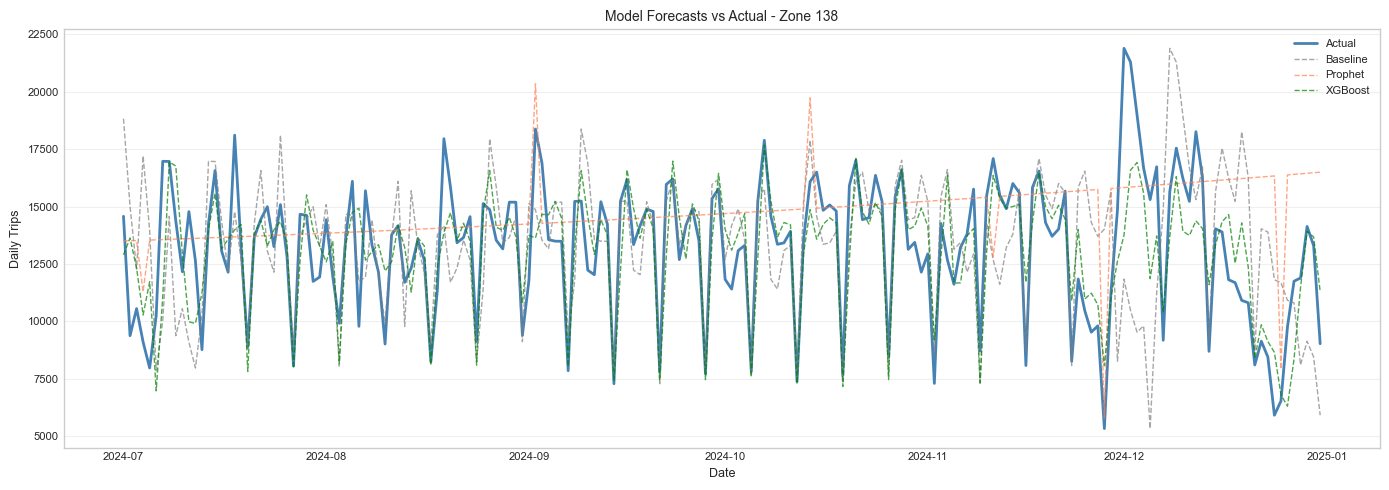

In [61]:
# Plot all forecasts against actual

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(pilot_test_df['date'], pilot_test_df['daily_trips'], 
        label='Actual', color='steelblue', linewidth=2)
ax.plot(pilot_test_df['date'], pilot_test_df['baseline_pred'], 
        label='Baseline', color='gray', linewidth=1, linestyle='--', alpha=0.7)
ax.plot(pilot_test_df['date'], pilot_test_df['prophet_pred'], 
        label='Prophet', color='coral', linewidth=1, linestyle='--', alpha=0.7)
ax.plot(pilot_test_xgb_df['date'], xgb_pred, 
        label='XGBoost', color='green', linewidth=1, linestyle='--', alpha=0.7)

ax.set_xlabel('Date')
ax.set_ylabel('Daily Trips')
ax.set_title(f'Model Forecasts vs Actual - Zone {PILOT_ZONE_ID}')
ax.legend()
plt.tight_layout()
plt.show()

**Interpretation:** XGBoost (green) tracks actual demand most closely, especially during transitions and the December holiday spike. Prophet (orange) overshoots peaks. The baseline (gray) lags behind as expected. This visual confirms metrics: feature engineering beats both the simple baseline and overly complex Prophet.

### 7.2 Select Best Model
Rank models by MAE and select best for final forecasting.

In [62]:
# Compare model performance and select winner

# Build comparison DataFrame from individual results
results_df = pd.DataFrame([baseline_results, prophet_results, xgb_results])

print(f"MODEL COMPARISON - Zone {PILOT_ZONE_ID} ({pilot_zone_name})")
print("=" * 50)
print(results_df.sort_values('MAE').to_string(index=False))

best_model = results_df.loc[results_df['MAE'].idxmin(), 'Model']
best_mae = results_df['MAE'].min()
print(f"\nBest model: {best_model} (MAE: {best_mae:,.0f} trips/day)")

MODEL COMPARISON - Zone 138 (LaGuardia Airport)
                    Model       MAE      RMSE    MAPE
                  XGBoost 1452.5300 1944.9700 11.5900
Baseline (Seasonal Naive) 2316.8300 3198.8900 18.7900
                  Prophet 2474.3100 3377.7400 23.7400

Best model: XGBoost (MAE: 1,453 trips/day)


##### Model Selection Reflection

**Why Prophet underperformed:** Prophet was designed for complex, irregular data with trend changes and messy seasonality (Taylor & Letham, 2018). This dataset's stable weekly patterns and low variability (CV < 0.3) didn't benefit from that flexibility. Prophet's complexity appeared to add noise to a fairly clean signal.

**Why XGBoost succeeded:** Gradient boosting methods like XGBoost are known top performers on stable, high-frequency demand data (Makridakis et al., 2022). Explicit lag features directly captured the consistent weekly structure. The model didn't need to find patterns as they were encoded based on EDA findings.

**Lesson learned:** Data characteristics should guide model selection. This analysis reflected the fact that stable, predictable data favors simpler, feature-driven approaches. More complex models like Prophet may be better suited for datasets with irregular patterns, trend shifts, or varying seasonality across series.

---

## 8. Forecast All Zones with Best Model
Runs best model across all zones and aggregates results.

### 8.1 Build Forecasting Pipeline
Create reusable function to train and forecast individual zones.

In [63]:
# Create reusable function to forecast a single zone with XGBoost - 1 time series

def forecast_zone_xgboost(
    zone_id: int, 
    train_df: pd.DataFrame, 
    test_df: pd.DataFrame, 
    feature_cols: list[str]
) -> pd.DataFrame:
    """Train XGBoost and generate forecasts for a single time-series (zone).
    
    Args:
        zone_id: Zone identifier to forecast
        train_df: Training data with all zones
        test_df: Test data with all zones
        feature_cols: List of feature column names
    
    Returns:
        DataFrame with row-level predictions for analysis and export
    """
    # Filter to zone
    zone_train = train_df[train_df['zone_id'] == zone_id].dropna(subset=feature_cols)
    zone_test = test_df[test_df['zone_id'] == zone_id].dropna(subset=feature_cols)
    
    X_train = zone_train[feature_cols]
    y_train = zone_train['daily_trips']
    X_test = zone_test[feature_cols]
    y_test = zone_test['daily_trips']
    
    # Train
    model = XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    # Return detailed results
    return pd.DataFrame({
        'zone_id': zone_id,
        'date': zone_test['date'].values,
        'actual': y_test.values,
        'forecast': model.predict(X_test),
        'day_name': zone_test['day_name'].values,
        'is_weekend': zone_test['is_weekend'].values,
        'is_holiday': zone_test['is_holiday'].values,
        'month': zone_test['month'].values,
        'season': zone_test['season'].values
    })

print("Forecasting pipeline defined")

Forecasting pipeline defined


### 8.2 Run Forecast on All Zones
Apply XGBoost model across all zones in dataset.

In [64]:
# Run forecasting pipeline on all  zones

from tqdm import tqdm

zone_ids = zone_daily_df['zone_id'].unique().tolist()
all_forecasts = []

print(f"Forecasting {len(zone_ids)} zones...")

for zone_id in tqdm(zone_ids):
    try:
        zone_forecast = forecast_zone_xgboost(zone_id, train_xgb_df, test_xgb_df, FEATURE_COLS)
        all_forecasts.append(zone_forecast)
    except Exception as e:
        print(f"Zone {zone_id} failed: {e}")

# Combine into single DataFrame
forecast_df = pd.concat(all_forecasts, ignore_index=True)

print(f"\nCompleted: {forecast_df['zone_id'].nunique()} zones")
print(f"Total forecast records: {len(forecast_df):,}")


Forecasting 256 zones...


100%|██████████| 256/256 [00:18<00:00, 13.55it/s]


Completed: 256 zones
Total forecast records: 47,104


### 8.3 Aggregate Forecast Results
Calculate zone-level metrics and overall model performance.

In [65]:
# Calculate zone-level metrics from detailed forecasts

zone_results_df = forecast_df.groupby('zone_id').apply(
    lambda x: pd.Series({
        'MAE': mean_absolute_error(x['actual'], x['forecast']),
        'zone_mean': x['actual'].mean(),
        'MAPE': (np.abs(x['actual'] - x['forecast']) / x['actual']).mean() * 100
    })
).reset_index()

zone_results_df['MAPE'] = zone_results_df['MAPE'].round(1)

# Overall performance
overall_mean_demand = zone_results_df['zone_mean'].mean()
overall_mae = zone_results_df['MAE'].mean()
overall_mape = zone_results_df['MAPE'].mean()

print("XGBOOST PERFORMANCE (All Zones)")
print("=" * 40)
print(f"Overall mean demand: {overall_mean_demand:,.0f} trips/day")
print(f"MAE:  {overall_mae:,.0f} trips/day ({overall_mae/overall_mean_demand*100:.1f}% of mean)")
print(f"MAPE: {overall_mape:.1f}%")

XGBOOST PERFORMANCE (All Zones)
Overall mean demand: 2,517 trips/day
MAE:  166 trips/day (6.6% of mean)
MAPE: 8.0%


**Interpretation:**
- **8.0% MAPE** across all zones shows strong performance and is within the <10% threshold
- **Lag features effectively model this data** — weekly demand patterns identified in EDA are captured across the full dataset and effectively forecast demand

### 8.4 Verify No Unaddressed Seasonality
Analyze residuals to check for remaining seasonal patterns.

In [ ]:
# Calculate residuals
forecast_df['residual'] = forecast_df['actual'] - forecast_df['forecast']

# Check for seasonal bias by month
print("RESIDUAL ANALYSIS")
print("=" * 50)
print(f"Overall mean daily demand: {forecast_df['actual'].mean():,.0f} trips/day")
print(f"Overall mean absolute residual: {forecast_df['residual'].abs().mean():,.0f} trips/day")

print("\nMean Residual by Month:")
monthly_residuals = forecast_df.groupby('month')['residual'].mean().round(0)
print(monthly_residuals.to_string())
print(f"   Residuals are {(monthly_residuals.abs().mean() / forecast_df['actual'].mean() * 100):.1f}% of mean demand")

print("\nMean Residual by Day of Week:")
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_residuals = forecast_df.groupby('day_name')['residual'].mean().round(0)
dow_residuals = dow_residuals.reindex(dow_order)
print(dow_residuals.to_string())
print(f"   Residuals are {(dow_residuals.abs().mean() / forecast_df['actual'].mean() * 100):.1f}% of mean demand")

RESIDUAL ANALYSIS
Overall mean daily demand: 2,517 trips/day
Overall mean absolute residual: 166 trips/day

Mean Residual by Month:
month
7    -13.0000
8    -27.0000
9     -4.0000
10    -6.0000
11    17.0000
12    67.0000
  → Residuals are 0.9% of mean demand

Mean Residual by Day of Week:
day_name
Monday        4.0000
Tuesday      27.0000
Wednesday   -10.0000
Thursday     10.0000
Friday       21.0000
Saturday     29.0000
Sunday      -44.0000
  → Residuals are 0.8% of mean demand


**Interpretation:** Mean residuals are small relative to demand. December shows slight under-prediction and Sunday slight over-prediction, but not enough bias that would require STL decomposition.

---

## 9. Evaluate Overall Performance
Analyze error distribution across zones, visualize performance patterns, and identify problem zones.

### 9.1 Visualize Performance Distribution
Chart forecast error across zones to review model generalization.

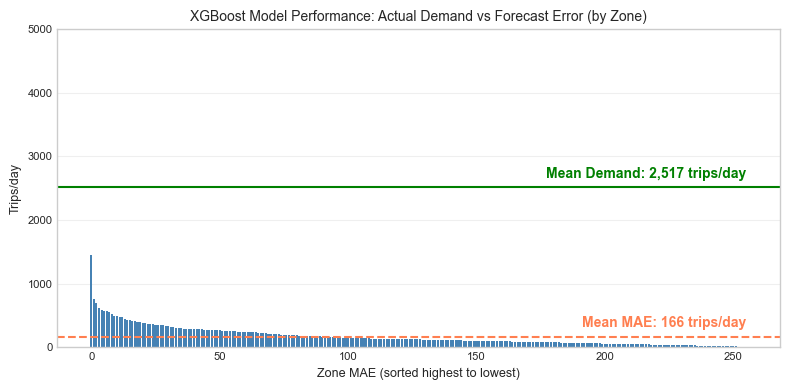

In [69]:
# Visualize MAE distribution across zones with demand 

fig, ax = plt.subplots(figsize=(8, 4))

sorted_results_df = zone_results_df.sort_values('MAE', ascending=False)
ax.bar(range(len(sorted_results_df)), sorted_results_df['MAE'], color='steelblue')

# Mean demand line with label
ax.axhline(overall_mean_demand, color='green', linestyle='-')
ax.text(len(sorted_results_df) - 1, overall_mean_demand + 100, 
        f"Mean Demand: {overall_mean_demand:,.0f} trips/day", 
        ha='right', va='bottom', color='green', fontweight='bold')

# Mean MAE line with label
ax.axhline(zone_results_df['MAE'].mean(), color='coral', linestyle='--')
ax.text(len(sorted_results_df) - 1, zone_results_df['MAE'].mean() + 100, 
        f"Mean MAE: {zone_results_df['MAE'].mean():,.0f} trips/day", 
        ha='right', va='bottom', color='coral', fontweight='bold')

ax.set_xlabel('Zone MAE (sorted highest to lowest)')
ax.set_ylabel('Trips/day')
ax.set_ylim(0, 5000)
ax.set_title('XGBoost Model Performance: Actual Demand vs Forecast Error (by Zone)')

plt.tight_layout()
plt.show()

**Interpretation:** The chart shows XGBoost achieves strong performance across all zones:
- **Mean forecast error:** 301 trips/day (6.5% of mean demand)
- **High-volume zones** show larger absolute errors but remain well below demand baseline
- **Model generalizes well** — the gap between actual demand and forecast error stays consistent across zones

In [70]:
# Validate forecast quality
assert overall_mape < 15, f"MAPE {overall_mape:.1f}% exceeds acceptable threshold"
assert zone_results_df['MAE'].min() > 0, "Invalid MAE values"
assert zone_results_df['zone_id'].nunique() == forecast_df['zone_id'].nunique(), "Missing zones in results"

### 9.2 Identify Problem Zones
Identify best and worst performing zones to understand error patterns.

In [73]:
# Find zones with highest forecast error that may need different approach

print("TOP 5 WORST PERFORMING ZONES")
worst_zones_df = zone_results_df.nlargest(5, 'MAE')
display(worst_zones_df)

print("\nTOP 5 BEST PERFORMING ZONES")
best_zones_df = zone_results_df.nsmallest(5, 'MAE')
display(best_zones_df)

TOP 5 WORST PERFORMING ZONES


,zone_id,MAE,zone_mean,MAPE
131,138,1452.5260,13219.6522,11.6000
125,132,750.6722,11599.7663,6.6000
154,161,689.1956,7487.6250,10.2000
76,79,614.7665,8338.6685,7.8000
222,230,584.4001,7910.3587,8.9000



TOP 5 BEST PERFORMING ZONES


,zone_id,MAE,zone_mean,MAPE
96,99,3.5205,13.9837,29.1000
255,265,4.4115,25.3043,19.3000
104,111,7.5322,23.7228,34.1000
5,8,8.8122,27.9130,34.9000
27,30,10.9225,42.7663,25.6000


**Interpretation:**
- **Worst performers are high-volume zones** Zone 138 (13,220 trips/day) has highest MAE (1,453) but MAPE remains acceptable at 11.6%
- **Best performers are lower-volume zones** averaging 2,500-3,000 trips/day with MAPE as low as 3.9%

---

## 10. Export Results
Export forecast and summary files for dashboard and reporting.

### 10.1 Add Calculated Metrics
Calculate forecast errors, zone baselines, and week-over-week changes.

In [74]:
# Calculate error metrics and context columns for Tableau export

# Error calculations
forecast_df['error'] = forecast_df['forecast'] - forecast_df['actual']
forecast_df['abs_error'] = forecast_df['error'].abs()
forecast_df['pct_error'] = (forecast_df['abs_error'] / forecast_df['actual'] * 100).round(2)

# Zone context
forecast_df = forecast_df.merge(
    zone_results_df[['zone_id', 'zone_mean']], 
    on='zone_id', 
    how='left'
)

# Week-over-week change
forecast_df = forecast_df.sort_values(['zone_id', 'date'])
forecast_df['forecast_wow_change'] = (
    forecast_df.groupby('zone_id')['forecast']
    .pct_change(7) * 100
).round(1)

# Forecast vs zone baseline
forecast_df['vs_zone_mean_pct'] = (
    (forecast_df['forecast'] - forecast_df['zone_mean']) / forecast_df['zone_mean'] * 100
).round(1)

print("Derived columns added")

Derived columns added


### 10.2 Add Zone Metadata
Merge zone names and borough information.

In [75]:
zone_metadata_df.head()

,zone_id,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [76]:
# Add zone names and borough for geographic filtering

forecast_df = forecast_df.merge(
   zone_metadata_df[['zone_id', 'Zone', 'Borough']], 
     on='zone_id', 
     how='left'
 )
# Rename fields for consistency 
forecast_df = forecast_df.rename(columns={'Zone': 'zone_name', 'Borough': 'borough'})
forecast_df.head()

,zone_id,date,actual,forecast,day_name,is_weekend,is_holiday,month,season,residual,error,abs_error,pct_error,zone_mean,forecast_wow_change,vs_zone_mean_pct,zone_name,borough
0,3,2024-07-01,1233,1381.8408,Monday,False,False,7,summer,-148.8408,148.8408,148.8408,12.0700,1406.5054,NaN,-1.8000,Allerton/Pelham Gardens,Bronx
1,3,2024-07-02,1274,1311.1003,Tuesday,False,False,7,summer,-37.1003,37.1003,37.1003,2.9100,1406.5054,NaN,-6.8000,Allerton/Pelham Gardens,Bronx
2,3,2024-07-03,1322,1423.0117,Wednesday,False,False,7,summer,-101.0117,101.0117,101.0117,7.6400,1406.5054,NaN,1.2000,Allerton/Pelham Gardens,Bronx
3,3,2024-07-04,1342,1267.9722,Thursday,False,True,7,summer,74.0278,-74.0278,74.0278,5.5200,1406.5054,NaN,-9.8000,Allerton/Pelham Gardens,Bronx
4,3,2024-07-05,1523,1541.7843,Friday,False,False,7,summer,-18.7843,18.7843,18.7843,1.2300,1406.5054,NaN,9.6000,Allerton/Pelham Gardens,Bronx


### 10.3 Export Forecast Results
Save detailed daily forecasts with error metrics to CSV.

In [77]:
# Save production-ready forecast dataset

# Column selection and ordering
export_columns = [
    # Identifiers
    'zone_id', 'zone_name', 'borough', 'date',
    # Core metrics
    'actual', 'forecast', 'error', 'abs_error', 'pct_error',
    # Context
    'zone_mean', 'vs_zone_mean_pct', 'forecast_wow_change',
    # Time dimensions
    'day_name', 'is_weekend', 'is_holiday', 'month', 'season'
]

export_cols = [c for c in export_columns if c in forecast_df.columns]
forecast_results_df = forecast_df[export_cols].copy()

# Save
forecast_results_df.to_csv(RESULTS_DIR / "forecast_results.csv", index=False)

print("\nFORECAST RESULTS EXPORT")
print(f"File: forecast_results.csv")
print(f"Zones: {forecast_results_df['zone_id'].nunique()}")
print(f"Date range: {forecast_results_df['date'].min()} to {forecast_results_df['date'].max()}")
print(f"Records: {len(forecast_results_df):,}")


FORECAST RESULTS EXPORT
File: forecast_results.csv
Zones: 256
Date range: 2024-07-01 00:00:00 to 2024-12-31 00:00:00
Records: 47,104


### 10.4 Export Summary Results
Save aggregated zone-level performance metrics to CSV.

In [78]:
# Export zone-level metrics in separate file

zone_results_df.to_csv(RESULTS_DIR / "summary_results.csv", index=False)

print("\nSUMMARY RESULTS EXPORT")
print(f"File: summary_results.csv")
print(f"Zones: {zone_results_df['zone_id'].nunique()}")
print(f"Metrics: MAE, MAPE, zone_mean")
print(f"Records: {len(zone_results_df):,}")


SUMMARY RESULTS EXPORT
File: summary_results.csv
Zones: 256
Metrics: MAE, MAPE, zone_mean
Records: 256


## Conclusion

XGBoost demonstrated the strongest performance, achieving 8.0% MAPE across all 256 zones. This met the <10% threshold goal established for the analysis. This confirms EDA findings that stable weekly patterns drive demand, making simple lag-based features more effective than complex seasonal decomposition.

**Key Findings:**
- XGBoost outperformed both Prophet (23.7% MAPE) and seasonal baseline (18.8% MAPE)
- Feature engineering with lag-7 directly captured weekly patterns identified in EDA
- Model generalizes well with consistent performance across all zones

**Limitations:** While the model performance was good, this analysis demonstrates 1-day-ahead forecasting. For operational 7-day planning, XGBoost would require recursive forecasting where predictions become inputs for subsequent days. Prophet naturally handles multi-day forecasts without this additional complexity.

### Future Work

- Extend forecasting across 1-7 day horizons using recursive/horizon forecasting
- Compare XGBoost vs Prophet performance at different forecast horizons
- Test model performance as new zones are added to the dataset

## References

- Hyndman, R.J., & Athanasopoulos, G. (2021). *Forecasting: Principles and Practice* (3rd ed.). https://otexts.com/fpp3/
- Makridakis, S., Spiliotis, E., & Assimakopoulos, V. (2022). M5 accuracy competition: Results, findings, and conclusions. *International Journal of Forecasting*, 38(4), 1346-1364.
- Taylor, S.J., & Letham, B. (2018). Forecasting at Scale. *The American Statistician*, 72(1), 37-45.
```